# EMF Data Cleaning and Normalization

This notebook performs comprehensive data cleaning and normalization on the synthetic EMF dataset including:

1. **Data Loading & Inspection**
2. **Missing Value Analysis**
3. **Outlier Detection & Handling**
4. **Data Cleaning**
5. **Feature Scaling & Normalization**
6. **Data Transformation**
7. **Final Dataset Export**

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ Libraries imported successfully!
NumPy version: 2.3.4
Pandas version: 2.3.3


## 2. Load and Inspect Data

In [2]:
# Load the EMF synthetic data
df_raw = pd.read_csv('EMF_Synthetic_Data.csv')

print("="*70)
print("ORIGINAL DATASET INFORMATION")
print("="*70)
print(f"\nDataset Shape: {df_raw.shape}")
print(f"Total Samples: {len(df_raw)}")
print(f"Total Features: {df_raw.shape[1]}")

print("\n" + "="*70)
print("COLUMN NAMES AND DATA TYPES")
print("="*70)
print(df_raw.dtypes)

print("\n" + "="*70)
print("FIRST 10 ROWS")
print("="*70)
print(df_raw.head(10))

print("\n" + "="*70)
print("BASIC STATISTICS")
print("="*70)
print(df_raw.describe())

ORIGINAL DATASET INFORMATION

Dataset Shape: (5000, 9)
Total Samples: 5000
Total Features: 9

COLUMN NAMES AND DATA TYPES
sample_id                 int64
temperature_C           float64
humidity_percent        float64
load_current_A          float64
distance_from_line_m    float64
vertical_distance_m     float64
E_field_V_m             float64
H_field_A_m             float64
is_outlier                 bool
dtype: object

FIRST 10 ROWS
   sample_id  temperature_C  humidity_percent  load_current_A  \
0          1      29.967142         50.647558      535.443405   
1          2      23.617357         84.772448     1093.503174   
2          3      31.476885         37.310486      489.801978   
3          4      40.230299         62.624150     1153.631699   
4          5      22.658466         61.867436      917.190465   
5          6      22.658630         78.846121      787.465247   
6          7      40.792128         11.724717      736.093285   
7          8      32.674347         11.78

## 3. Missing Value Analysis

In [3]:
# Check for missing values
print("="*70)
print("MISSING VALUE ANALYSIS")
print("="*70)

missing_values = df_raw.isnull().sum()
missing_percent = (df_raw.isnull().sum() / len(df_raw)) * 100

missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': missing_values.values,
    'Missing_Percent': missing_percent.values
})

print("\nMissing Values Summary:")
print(missing_df)

if missing_df['Missing_Count'].sum() == 0:
    print("\n✓ No missing values found in the dataset!")
else:
    print(f"\n⚠ Total missing values: {missing_df['Missing_Count'].sum()}")
    
# Visualize missing values
if missing_df['Missing_Count'].sum() > 0:
    plt.figure(figsize=(10, 6))
    missing_df[missing_df['Missing_Count'] > 0].plot(
        x='Column', 
        y='Missing_Percent', 
        kind='bar', 
        color='red', 
        alpha=0.7
    )
    plt.title('Missing Values Percentage by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xlabel('Column Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No visualization needed - dataset is complete!")

MISSING VALUE ANALYSIS

Missing Values Summary:
                 Column  Missing_Count  Missing_Percent
0             sample_id              0              0.0
1         temperature_C              0              0.0
2      humidity_percent              0              0.0
3        load_current_A              0              0.0
4  distance_from_line_m              0              0.0
5   vertical_distance_m              0              0.0
6           E_field_V_m              0              0.0
7           H_field_A_m              0              0.0
8            is_outlier              0              0.0

✓ No missing values found in the dataset!

✓ No visualization needed - dataset is complete!


## 4. Outlier Detection and Analysis

In [4]:
# Outlier detection using multiple methods
print("="*70)
print("OUTLIER DETECTION ANALYSIS")
print("="*70)

# Select numeric columns (exclude sample_id and is_outlier)
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['sample_id', 'is_outlier']]

print(f"\nAnalyzing outliers for: {numeric_cols}\n")

# Method 1: IQR (Interquartile Range) Method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Method 2: Z-Score Method
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = np.abs(stats.zscore(data[column]))
    outliers = data[z_scores > threshold]
    return outliers

# Analyze outliers for each numeric column
outlier_summary = []

for col in numeric_cols:
    # IQR Method
    iqr_outliers, lower, upper = detect_outliers_iqr(df_raw, col)
    iqr_count = len(iqr_outliers)
    iqr_percent = (iqr_count / len(df_raw)) * 100
    
    # Z-Score Method
    zscore_outliers = detect_outliers_zscore(df_raw, col)
    zscore_count = len(zscore_outliers)
    zscore_percent = (zscore_count / len(df_raw)) * 100
    
    outlier_summary.append({
        'Feature': col,
        'IQR_Outliers': iqr_count,
        'IQR_Percent': f"{iqr_percent:.2f}%",
        'ZScore_Outliers': zscore_count,
        'ZScore_Percent': f"{zscore_percent:.2f}%",
        'Lower_Bound': f"{lower:.2f}",
        'Upper_Bound': f"{upper:.2f}"
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

# Check labeled outliers
if 'is_outlier' in df_raw.columns:
    labeled_outliers = df_raw['is_outlier'].sum()
    print(f"\n✓ Labeled outliers in dataset: {labeled_outliers} ({labeled_outliers/len(df_raw)*100:.2f}%)")

OUTLIER DETECTION ANALYSIS

Analyzing outliers for: ['temperature_C', 'humidity_percent', 'load_current_A', 'distance_from_line_m', 'vertical_distance_m', 'E_field_V_m', 'H_field_A_m']

             Feature  IQR_Outliers IQR_Percent  ZScore_Outliers ZScore_Percent Lower_Bound Upper_Bound
       temperature_C            24       0.48%                7          0.14%       -1.44       51.52
    humidity_percent             0       0.00%                0          0.00%      -18.86      120.80
      load_current_A             5       0.10%                0          0.00%      212.00     1666.88
distance_from_line_m             0       0.00%                0          0.00%     -132.26      261.19
 vertical_distance_m           902      18.04%              178          3.56%       -1.78        2.96
         E_field_V_m           234       4.68%               75          1.50%   -25115.82    54813.68
         H_field_A_m           116       2.32%               47          0.94%       -7.36   

### 4.1 Visualize Outliers with Box Plots

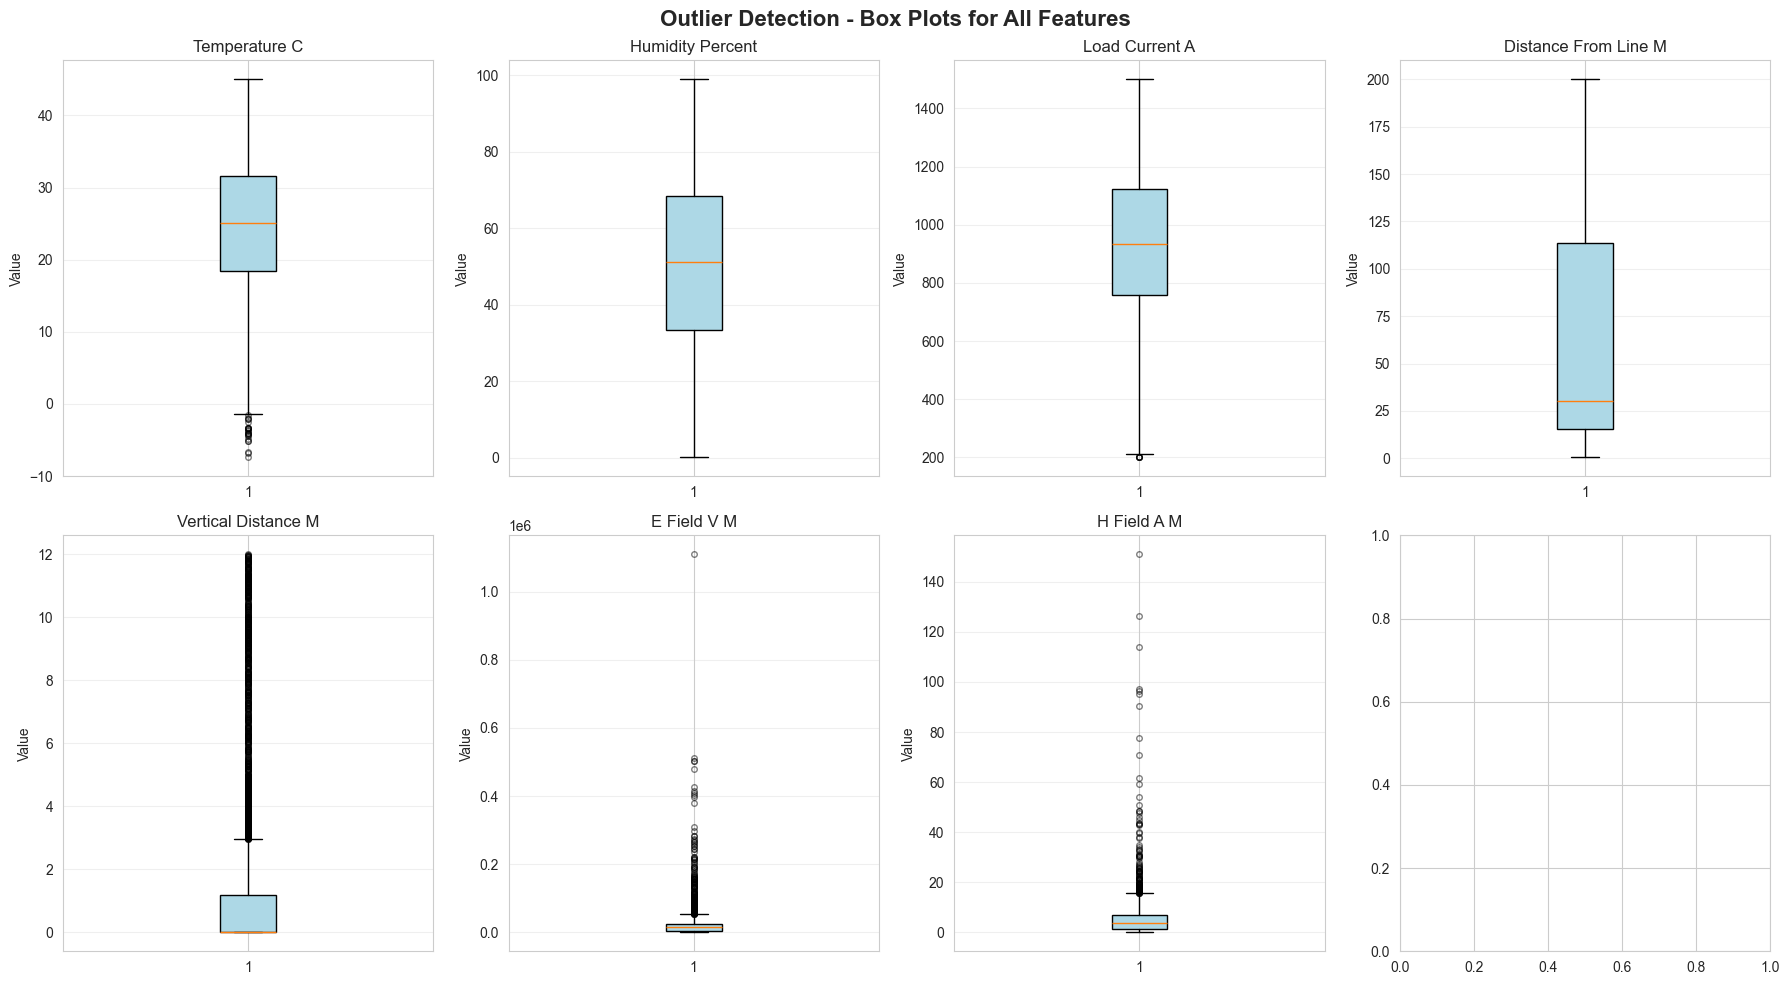

In [5]:
# Visualize outliers using box plots
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
fig.suptitle('Outlier Detection - Box Plots for All Features', fontsize=16, fontweight='bold')

for idx, col in enumerate(numeric_cols):
    row = idx // 4
    col_idx = idx % 4
    ax = axes[row, col_idx]
    
    # Create box plot
    bp = ax.boxplot(df_raw[col], patch_artist=True, vert=True)
    
    # Color the box
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    # Highlight outliers
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5, markersize=4)
    
    ax.set_title(col.replace('_', ' ').title())
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Data Cleaning

### 5.1 Handle Outliers (Multiple Strategies)

In [6]:
# Strategy 1: Remove labeled outliers
df_cleaned_remove = df_raw[~df_raw['is_outlier']].copy()
print("="*70)
print("STRATEGY 1: REMOVE OUTLIERS")
print("="*70)
print(f"Original size: {len(df_raw)}")
print(f"After removing outliers: {len(df_cleaned_remove)}")
print(f"Removed: {len(df_raw) - len(df_cleaned_remove)} samples ({(len(df_raw) - len(df_cleaned_remove))/len(df_raw)*100:.2f}%)")

# Strategy 2: Cap outliers (Winsorization)
df_cleaned_cap = df_raw.copy()

for col in numeric_cols:
    if col not in ['sample_id']:
        Q1 = df_cleaned_cap[col].quantile(0.25)
        Q3 = df_cleaned_cap[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values
        df_cleaned_cap[col] = df_cleaned_cap[col].clip(lower=lower_bound, upper=upper_bound)

print("\n" + "="*70)
print("STRATEGY 2: CAP OUTLIERS (Winsorization)")
print("="*70)
print("✓ Outliers capped at IQR boundaries")
print(f"Dataset size maintained: {len(df_cleaned_cap)}")

# Strategy 3: Keep outliers with flag
df_cleaned_flag = df_raw.copy()

print("\n" + "="*70)
print("STRATEGY 3: KEEP OUTLIERS WITH FLAG")
print("="*70)
print("✓ Outliers retained with 'is_outlier' flag")
print(f"Dataset size: {len(df_cleaned_flag)}")
print(f"Normal samples: {(~df_cleaned_flag['is_outlier']).sum()}")
print(f"Outlier samples: {df_cleaned_flag['is_outlier'].sum()}")

# Choose strategy for further processing
print("\n" + "="*70)
print("SELECTED STRATEGY FOR NORMALIZATION")
print("="*70)
print("Using Strategy 1: Remove Outliers")
print("This provides clean data for normalization and modeling")
print("="*70)

df_clean = df_cleaned_remove.copy()

STRATEGY 1: REMOVE OUTLIERS
Original size: 5000
After removing outliers: 4850
Removed: 150 samples (3.00%)

STRATEGY 2: CAP OUTLIERS (Winsorization)
✓ Outliers capped at IQR boundaries
Dataset size maintained: 5000

STRATEGY 3: KEEP OUTLIERS WITH FLAG
✓ Outliers retained with 'is_outlier' flag
Dataset size: 5000
Normal samples: 4850
Outlier samples: 150

SELECTED STRATEGY FOR NORMALIZATION
Using Strategy 1: Remove Outliers
This provides clean data for normalization and modeling


### 5.2 Remove Duplicates

In [7]:
# Check for duplicate rows
duplicates = df_clean.duplicated()
duplicate_count = duplicates.sum()

print("="*70)
print("DUPLICATE ANALYSIS")
print("="*70)
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicate rows...")
    df_clean = df_clean.drop_duplicates()
    print(f"✓ Duplicates removed. New size: {len(df_clean)}")
else:
    print("✓ No duplicate rows found!")

print(f"\nFinal cleaned dataset size: {len(df_clean)} samples")

DUPLICATE ANALYSIS
Number of duplicate rows: 0
✓ No duplicate rows found!

Final cleaned dataset size: 4850 samples


## 6. Data Normalization and Scaling

We'll apply multiple normalization techniques and compare them.

In [8]:
# Prepare features for normalization (exclude sample_id and is_outlier)
features_to_normalize = [col for col in df_clean.columns 
                         if col not in ['sample_id', 'is_outlier']]

print("="*70)
print("FEATURES TO NORMALIZE")
print("="*70)
print(features_to_normalize)
print(f"\nTotal features: {len(features_to_normalize)}")

# Create a copy for normalization
X = df_clean[features_to_normalize].copy()

print("\n" + "="*70)
print("ORIGINAL DATA STATISTICS (Before Normalization)")
print("="*70)
print(X.describe())

FEATURES TO NORMALIZE
['temperature_C', 'humidity_percent', 'load_current_A', 'distance_from_line_m', 'vertical_distance_m', 'E_field_V_m', 'H_field_A_m']

Total features: 7

ORIGINAL DATA STATISTICS (Before Normalization)
       temperature_C  humidity_percent  load_current_A  distance_from_line_m  \
count    4850.000000       4850.000000     4850.000000           4850.000000   
mean       25.027671         50.987407      943.621294             64.947369   
std         9.764346         22.262000      258.602768             60.699253   
min        -7.412673          0.151073      200.000000              0.500494   
25%        18.468471         33.832685      757.417704             15.377546   
50%        25.192459         51.376067      931.830984             30.766220   
75%        31.718412         68.609609     1119.301428            113.399734   
max        45.000000         98.975940     1500.000000            199.995265   

       vertical_distance_m    E_field_V_m  H_field_A_m  

### 6.1 StandardScaler (Z-score Normalization)

Transforms features to have mean = 0 and std = 1

In [9]:
# Apply StandardScaler
scaler_standard = StandardScaler()
X_standard = scaler_standard.fit_transform(X)
X_standard_df = pd.DataFrame(X_standard, columns=features_to_normalize, index=X.index)

print("="*70)
print("STANDARDSCALER (Z-SCORE NORMALIZATION)")
print("="*70)
print("\nFormula: z = (x - μ) / σ")
print("Result: Mean ≈ 0, Std ≈ 1")
print("\nAfter StandardScaler:")
print(X_standard_df.describe())

# Verify normalization
print("\n✓ Verification:")
for col in features_to_normalize:
    mean_val = X_standard_df[col].mean()
    std_val = X_standard_df[col].std()
    print(f"  {col}: Mean = {mean_val:.6f}, Std = {std_val:.6f}")

STANDARDSCALER (Z-SCORE NORMALIZATION)

Formula: z = (x - μ) / σ
Result: Mean ≈ 0, Std ≈ 1

After StandardScaler:
       temperature_C  humidity_percent  load_current_A  distance_from_line_m  \
count   4.850000e+03      4.850000e+03    4.850000e+03          4.850000e+03   
mean   -2.138953e-16     -5.127628e-18    2.871472e-16         -5.896772e-17   
std     1.000103e+00      1.000103e+00    1.000103e+00          1.000103e+00   
min    -3.322669e+00     -2.283783e+00   -2.875831e+00         -1.061850e+00   
25%    -6.718193e-01     -7.706626e-01   -7.201114e-01         -8.167306e-01   
50%     1.687828e-02      1.746025e-02   -4.559706e-02         -5.631811e-01   
75%     6.852923e-01      7.916637e-01    6.794136e-01          7.983189e-01   
max     2.045645e+00      2.155848e+00    2.151702e+00          2.225099e+00   

       vertical_distance_m   E_field_V_m   H_field_A_m  
count         4.850000e+03  4.850000e+03  4.850000e+03  
mean          1.904548e-17 -7.837946e-17  3.662591e

### 6.2 MinMaxScaler (Normalization to 0-1 Range)

Scales features to a fixed range [0, 1]

In [10]:
# Apply MinMaxScaler
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)
X_minmax_df = pd.DataFrame(X_minmax, columns=features_to_normalize, index=X.index)

print("="*70)
print("MINMAXSCALER (0-1 NORMALIZATION)")
print("="*70)
print("\nFormula: x_norm = (x - x_min) / (x_max - x_min)")
print("Result: Min = 0, Max = 1")
print("\nAfter MinMaxScaler:")
print(X_minmax_df.describe())

# Verify normalization
print("\n✓ Verification:")
for col in features_to_normalize:
    min_val = X_minmax_df[col].min()
    max_val = X_minmax_df[col].max()
    print(f"  {col}: Min = {min_val:.6f}, Max = {max_val:.6f}")

MINMAXSCALER (0-1 NORMALIZATION)

Formula: x_norm = (x - x_min) / (x_max - x_min)
Result: Min = 0, Max = 1

After MinMaxScaler:
       temperature_C  humidity_percent  load_current_A  distance_from_line_m  \
count    4850.000000       4850.000000     4850.000000           4850.000000   
mean        0.618941          0.514408        0.572016              0.323050   
std         0.186297          0.225267        0.198925              0.304265   
min         0.000000          0.000000        0.000000              0.000000   
25%         0.493796          0.340821        0.428783              0.074574   
50%         0.622085          0.518341        0.562947              0.151712   
75%         0.746596          0.692726        0.707155              0.565926   
max         1.000000          1.000000        1.000000              1.000000   

       vertical_distance_m  E_field_V_m  H_field_A_m  
count          4850.000000  4850.000000  4850.000000  
mean              0.113396     0.035917  

### 6.3 RobustScaler (Robust to Outliers)

Uses median and IQR instead of mean and std

In [11]:
# Apply RobustScaler
scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(X)
X_robust_df = pd.DataFrame(X_robust, columns=features_to_normalize, index=X.index)

print("="*70)
print("ROBUSTSCALER (ROBUST TO OUTLIERS)")
print("="*70)
print("\nFormula: x_scaled = (x - median) / IQR")
print("Result: Median ≈ 0, IQR-based scaling")
print("\nAfter RobustScaler:")
print(X_robust_df.describe())

ROBUSTSCALER (ROBUST TO OUTLIERS)

Formula: x_scaled = (x - median) / IQR
Result: Median ≈ 0, IQR-based scaling

After RobustScaler:
       temperature_C  humidity_percent  load_current_A  distance_from_line_m  \
count   4.850000e+03       4850.000000     4850.000000          4.850000e+03   
mean   -1.243691e-02         -0.011176        0.032580          3.487083e-01   
std     7.369351e-01          0.640137        0.714602          6.192399e-01   
min    -2.460776e+00         -1.472959       -2.022282         -3.087640e-01   
25%    -5.074731e-01         -0.504455       -0.481959         -1.569917e-01   
50%    -1.340616e-16          0.000000        0.000000          1.810618e-17   
75%     4.925269e-01          0.495545        0.518041          8.430083e-01   
max     1.494915e+00          1.368720        1.570032          1.726436e+00   

       vertical_distance_m   E_field_V_m   H_field_A_m  
count          4850.000000  4.850000e+03  4.850000e+03  
mean              1.163089  2.07

### 6.4 Compare Normalization Methods

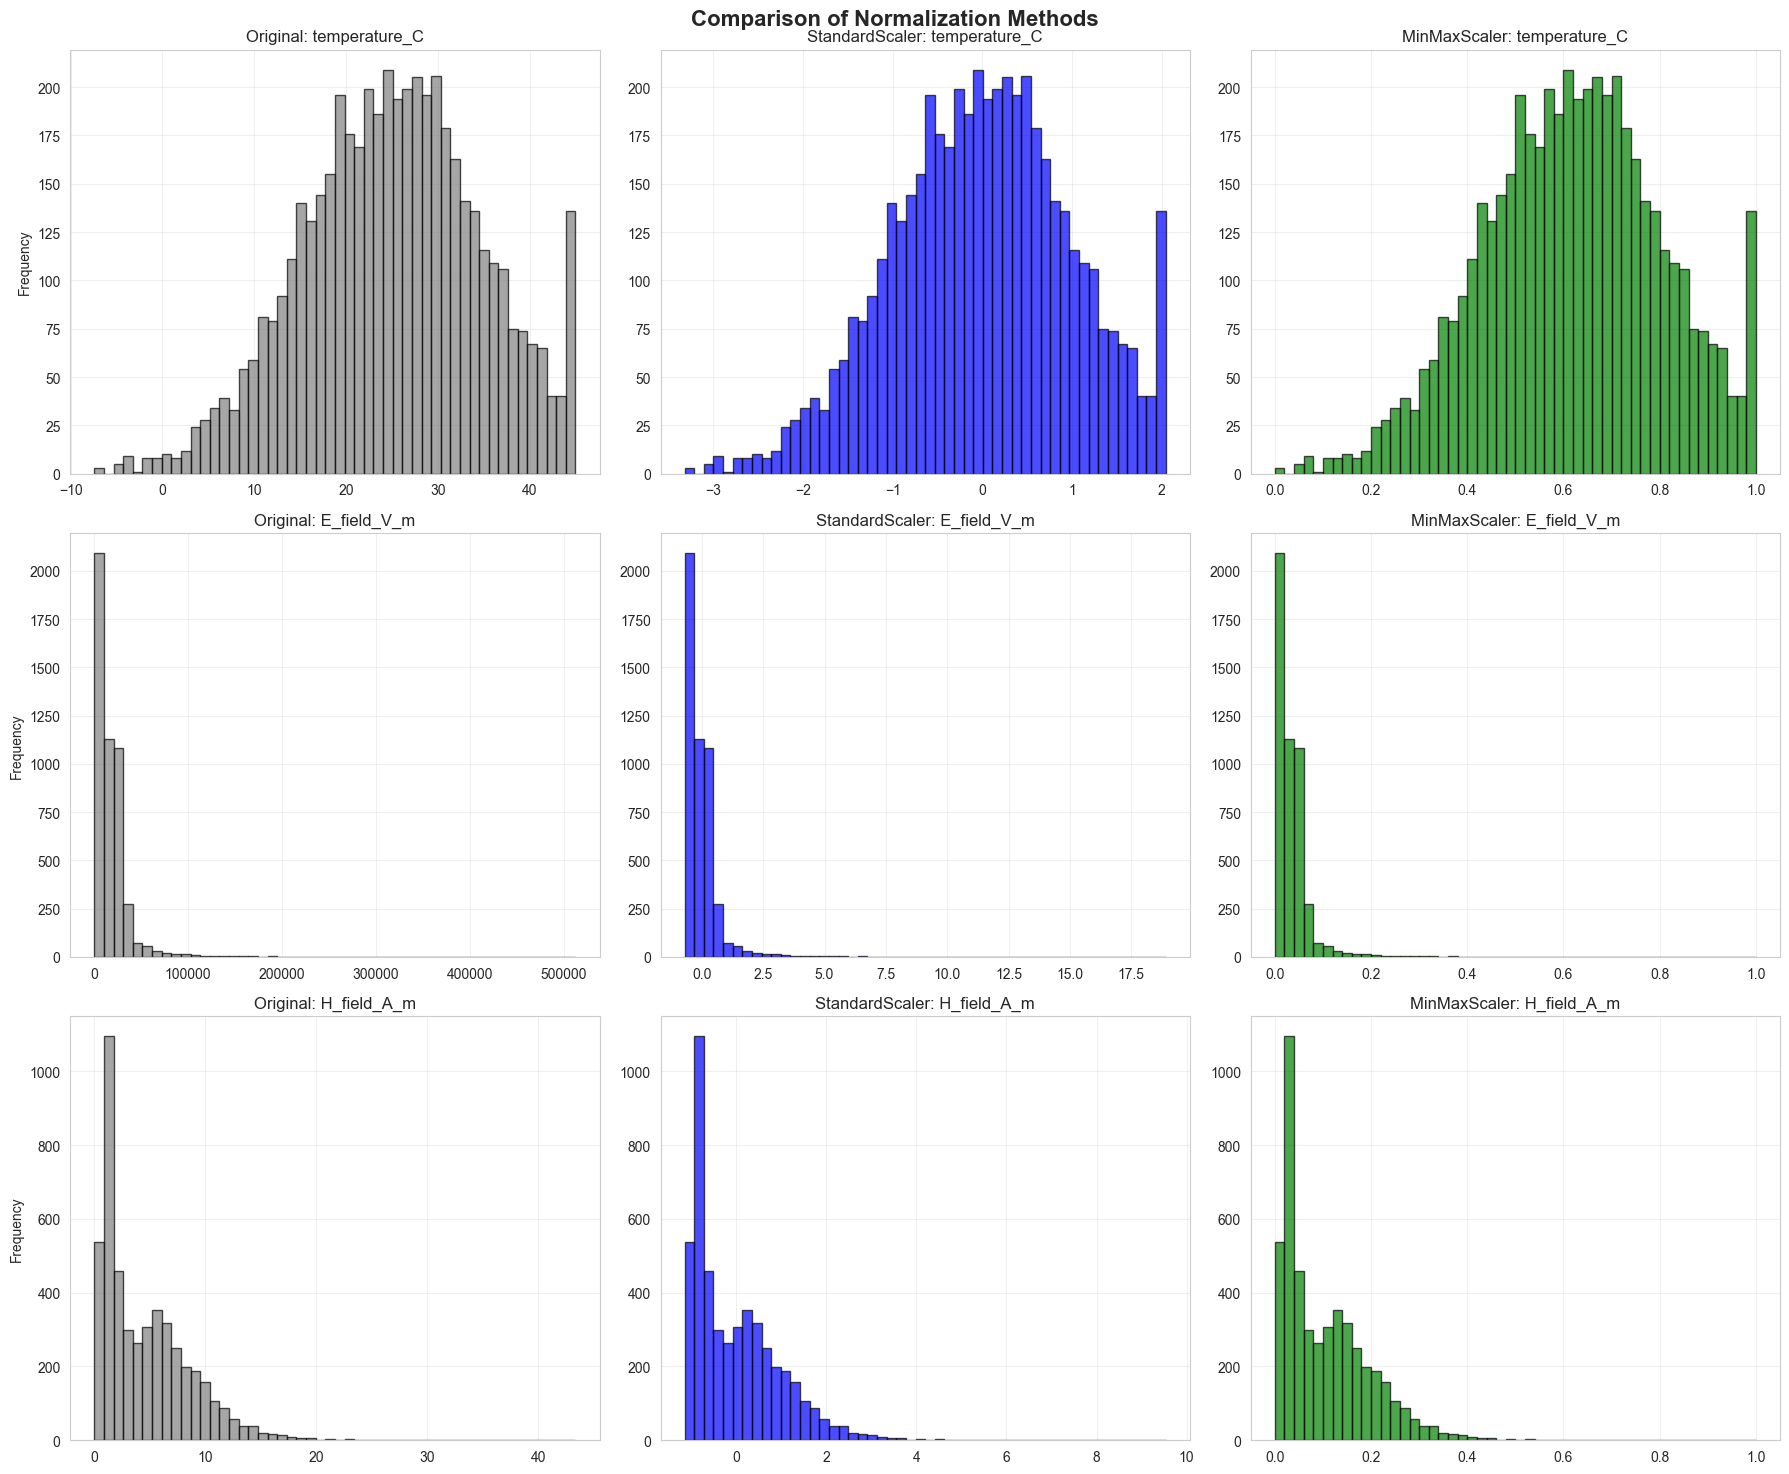

In [12]:
# Visualize comparison of normalization methods
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Comparison of Normalization Methods', fontsize=16, fontweight='bold')

# Select three features for visualization
sample_features = ['temperature_C', 'E_field_V_m', 'H_field_A_m']

for idx, feature in enumerate(sample_features):
    # Original data
    axes[idx, 0].hist(X[feature], bins=50, color='gray', alpha=0.7, edgecolor='black')
    axes[idx, 0].set_title(f'Original: {feature}')
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # StandardScaler
    axes[idx, 1].hist(X_standard_df[feature], bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[idx, 1].set_title(f'StandardScaler: {feature}')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # MinMaxScaler
    axes[idx, 2].hist(X_minmax_df[feature], bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[idx, 2].set_title(f'MinMaxScaler: {feature}')
    axes[idx, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Export Cleaned and Normalized Data

In [13]:
# Export cleaned data (outliers removed, no normalization)
df_clean_export = df_clean.copy()
df_clean_export.to_csv('EMF_Data_Cleaned.csv', index=False)
print("✓ Exported: EMF_Data_Cleaned.csv")
print(f"  Size: {len(df_clean_export)} samples")

# Export StandardScaler normalized data
df_standard_export = X_standard_df.copy()
df_standard_export.insert(0, 'sample_id', df_clean['sample_id'].values)
df_standard_export.to_csv('EMF_Data_StandardScaler.csv', index=False)
print("\n✓ Exported: EMF_Data_StandardScaler.csv")
print(f"  Size: {len(df_standard_export)} samples")
print("  Method: Z-score normalization (mean=0, std=1)")

# Export MinMaxScaler normalized data
df_minmax_export = X_minmax_df.copy()
df_minmax_export.insert(0, 'sample_id', df_clean['sample_id'].values)
df_minmax_export.to_csv('EMF_Data_MinMaxScaler.csv', index=False)
print("\n✓ Exported: EMF_Data_MinMaxScaler.csv")
print(f"  Size: {len(df_minmax_export)} samples")
print("  Method: Min-Max normalization (range 0-1)")

# Export RobustScaler normalized data
df_robust_export = X_robust_df.copy()
df_robust_export.insert(0, 'sample_id', df_clean['sample_id'].values)
df_robust_export.to_csv('EMF_Data_RobustScaler.csv', index=False)
print("\n✓ Exported: EMF_Data_RobustScaler.csv")
print(f"  Size: {len(df_robust_export)} samples")
print("  Method: Robust scaling (median, IQR)")

print("\n" + "="*70)
print("ALL DATASETS EXPORTED SUCCESSFULLY!")
print("="*70)

✓ Exported: EMF_Data_Cleaned.csv
  Size: 4850 samples

✓ Exported: EMF_Data_StandardScaler.csv
  Size: 4850 samples
  Method: Z-score normalization (mean=0, std=1)

✓ Exported: EMF_Data_MinMaxScaler.csv
  Size: 4850 samples
  Method: Min-Max normalization (range 0-1)

✓ Exported: EMF_Data_RobustScaler.csv
  Size: 4850 samples
  Method: Robust scaling (median, IQR)

ALL DATASETS EXPORTED SUCCESSFULLY!


## 8. Summary Report

In [14]:
print("="*70)
print("DATA CLEANING AND NORMALIZATION - SUMMARY REPORT")
print("="*70)

print("\n1. ORIGINAL DATASET:")
print(f"   - Total samples: {len(df_raw)}")
print(f"   - Features: {df_raw.shape[1]}")
print(f"   - Outliers (labeled): {df_raw['is_outlier'].sum()} ({df_raw['is_outlier'].sum()/len(df_raw)*100:.2f}%)")

print("\n2. DATA CLEANING PERFORMED:")
print(f"   ✓ Removed outliers: {len(df_raw) - len(df_clean)} samples")
print(f"   ✓ Checked for duplicates: {duplicate_count} found")
print(f"   ✓ Checked for missing values: 0 found")
print(f"   ✓ Final cleaned dataset: {len(df_clean)} samples")

print("\n3. NORMALIZATION METHODS APPLIED:")
print("   ✓ StandardScaler (Z-score)")
print("     - Mean ≈ 0, Std ≈ 1")
print("     - Best for: Algorithms assuming normal distribution (SVM, Neural Networks)")
print("   ")
print("   ✓ MinMaxScaler (0-1 range)")
print("     - Min = 0, Max = 1")
print("     - Best for: Algorithms bounded inputs (Neural Networks, Image Processing)")
print("   ")
print("   ✓ RobustScaler (Median/IQR)")
print("     - Median ≈ 0, IQR-based")
print("     - Best for: Data with remaining outliers")

print("\n4. EXPORTED FILES:")
print("   1. EMF_Data_Cleaned.csv - Cleaned, no normalization")
print("   2. EMF_Data_StandardScaler.csv - StandardScaler normalized")
print("   3. EMF_Data_MinMaxScaler.csv - MinMaxScaler normalized")
print("   4. EMF_Data_RobustScaler.csv - RobustScaler normalized")

print("\n5. RECOMMENDATION:")
print("   → Use StandardScaler for most ML models (Random Forest, SVM, Neural Networks)")
print("   → Use MinMaxScaler for Deep Learning with bounded activations")
print("   → Use RobustScaler if outliers are still a concern")

print("\n" + "="*70)
print("DATA READY FOR MACHINE LEARNING!")
print("="*70)

DATA CLEANING AND NORMALIZATION - SUMMARY REPORT

1. ORIGINAL DATASET:
   - Total samples: 5000
   - Features: 9
   - Outliers (labeled): 150 (3.00%)

2. DATA CLEANING PERFORMED:
   ✓ Removed outliers: 150 samples
   ✓ Checked for duplicates: 0 found
   ✓ Checked for missing values: 0 found
   ✓ Final cleaned dataset: 4850 samples

3. NORMALIZATION METHODS APPLIED:
   ✓ StandardScaler (Z-score)
     - Mean ≈ 0, Std ≈ 1
     - Best for: Algorithms assuming normal distribution (SVM, Neural Networks)
   
   ✓ MinMaxScaler (0-1 range)
     - Min = 0, Max = 1
     - Best for: Algorithms bounded inputs (Neural Networks, Image Processing)
   
   ✓ RobustScaler (Median/IQR)
     - Median ≈ 0, IQR-based
     - Best for: Data with remaining outliers

4. EXPORTED FILES:
   1. EMF_Data_Cleaned.csv - Cleaned, no normalization
   2. EMF_Data_StandardScaler.csv - StandardScaler normalized
   3. EMF_Data_MinMaxScaler.csv - MinMaxScaler normalized
   4. EMF_Data_RobustScaler.csv - RobustScaler normaliz